# Minimal implementation example using pyiron for software packages with or without executable

We show how to implement a code in pyiron using an example of Gnuplot fit, which requires the executable `gnuplot` and an input file, issueing an output file after execution. We show the same process using `numpy.polyfit`, to show an example for the same procedure without executables.

For software packages which requires an executable, we can use `TemplateJob` from `pyiron_base`. Otherwise if it can run only within python, you can use `PythonTemplateJob`.

Detailed explanation:

Let's say we have a certain number of data points `x` and `y`, which we know have a linear relationship. With the usual gnuplot workflow, we would store the data file (which we call `xy.dat`), which should be stored as:

```
x_1 y_1
x_2 y_2
...
x_n y_n
```

Then the fit parameters can be obtained through:

```
f(x) = a*x + b
fit f(x) "xy.dat" using 1:2 via a,b
```

The actual parameters will be stored in `fit.log`, which has to be parsed.

For the second part, we show the same example using `numpy.polyfit`, which does not require an executable, but can do the same.

In [1]:
from pyiron_base import PythonTemplateJob, TemplateJob, Project
import numpy as np
import matplotlib.pylab as plt
import os

In [2]:
# We take 10 points, simulating some simulation results, which should be able to be represented by a linear function
n = 10
x = np.linspace(0, 1, n)
y = x.copy()
# Add fluctions to make it exciting
x_measure = x + 0.01 * np.random.randn(n)
y_measure = y + 0.01 * np.random.randn(n)

In [3]:
pr = Project("EXAMPLE")

## Part I: Executable example (Gnuplot)

### Parser

In [4]:
# These are the gnuplot parsers, required to extract the fit parameters, i.e. slope and intercept

def _get_gnuplot_parameter_line(content):
    for ii, line in enumerate(content):
        if line.startswith("Final set of parameters"):
            return ii + 2
    raise ValueError("line not found")
    
def get_gnuplot_parameters(content):
    parameter_line = _get_gnuplot_parameter_line(content)
    slope = float(content[parameter_line].split("=")[1].split()[0])
    intercept = float(content[parameter_line + 1].split("=")[1].split()[0])
    return slope, intercept

### Job class

In [5]:
class Gnuplot(TemplateJob):
    def __init__(self, project, job_name):
        super().__init__(project, job_name)
        self.executable = "gnuplot \"input.gnu\"" # executable, required
        # self.input is available to the user and it can store anything that can be serialized.
        # The content will be automatically stored when `job.run()` is called
        self.input.x = None
        self.input.y = None
        self.input.gnuplot_file = "f(x) = a*x+b\nfit f(x) \"xy.dat\" using 1:2 via a,b"

    # `write_input` is called before the executable is called
    def write_input(self):
        data_file = os.path.join(self.working_directory, 'xy.dat')
        gnuplot_file = os.path.join(self.working_directory, 'input.gnu')
        np.savetxt(data_file, np.stack((self.input.x, self.input.y), axis=-1))
        with open(gnuplot_file, "w") as f:
            f.write(self.input.gnuplot_file)
        
    # `collect_output` is called after the executable is called.
    # It should include the parsing process
    def collect_output(self):
        data_file = os.path.join(self.working_directory, 'fit.log')
        with open(data_file, "r") as f:
            content = f.readlines()
        # Just like `self.input`, `self.output` is available to the user.
        # The content will be stored when `self.to_hdf()` is called.
        self.output.slope, self.output.intercept = get_gnuplot_parameters(content)
        self.to_hdf()
        
    # Optional function. If defined, it will be called before `write_input`
    def validate_ready_to_run(self):
        if self.input.x is None or self.input.y is None:
            raise ValueError("x and/or y is not defined")

### User interface (independent of with or without executable)

In [6]:
job = pr.create_job(Gnuplot, job_name="gnuplot_example")
job.input.x = x_measure
job.input.y = y_measure

job.run()

The job gnuplot_example was saved and received the ID: 6115


### Output visualization (independent of with or without executable)

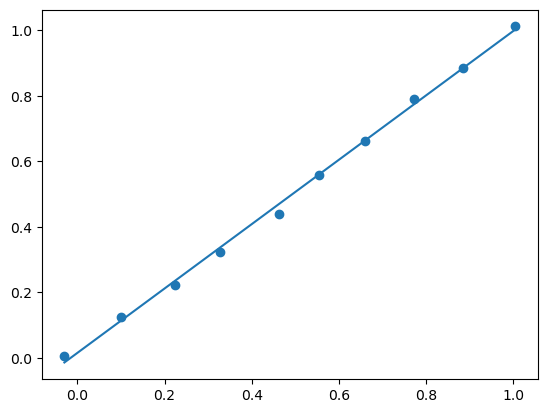

In [7]:
plt.scatter(x_measure, y_measure, label="input data")
plt.plot(x_measure, x_measure * job.output.slope + job.output.intercept, label="output data")

## Part II: Non-Executable example (`numpy.polyfit`)

### Job class

In [8]:
class NumpyFit(PythonTemplateJob):
    def __init__(self, project, job_name):
        super().__init__(project, job_name)
        self.input.x = None
        self.input.y = None

    def run_static(self):
        coeff = np.polyfit(self.input.x, self.input.y, deg=1)
        self.output.slope, self.output.intercept = coeff
        self.to_hdf()
        
    def validate_ready_to_run(self):
        if self.input.x is None or self.input.y is None:
            raise ValueError("x and/or y is not defined")

### User interface (independent of with or without executable)

In [9]:
job = pr.create_job(NumpyFit, job_name="numpy_example")
job.input.x = x_measure
job.input.y = y_measure

job.run()

The job numpy_example was saved and received the ID: 6116


### Output visualization (independent of with or without executable)

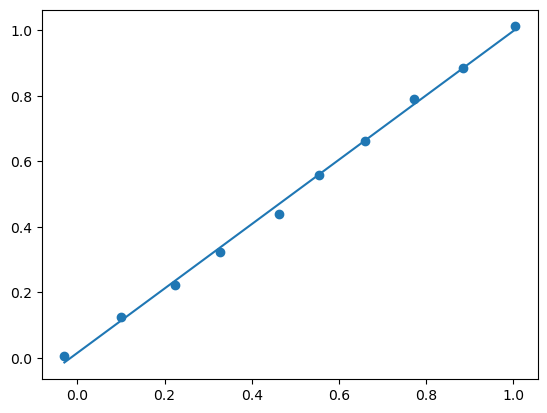

In [10]:
plt.scatter(x_measure, y_measure, label="input data")
plt.plot(x_measure, x_measure * job.output.slope + job.output.intercept, label="output data")